# Lab - Data-Centric Evaluation of ML Models

This lab is intended to accompany the lecture on Data-Centric Evaluation of ML Models. In this lab, you are given a training dataset and your goal is to improve the dataset in order to boost the accuracy of a fixed classification model on a given (fixed) test dataset. Reviewing the lecture notes will be helpful to get some ideas.

You can get all the dependencies you need for this notebook by running:

In [26]:
!pip install cleanlab matplotlib

In [46]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score

import matplotlib.pyplot as plt

In [47]:
SEED = 123
np.random.seed(SEED)  # for reproducibility

# Load dataset

The data come from a 3-class classification task where the goal is to predict `y` based on features `x1`, ..., `x5`.
We convert the data to a numpy array format.

In [53]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [54]:
df.head()

,x0,x1,x2,x3,x4,x5,y
0,-0.333489,-0.770208,-2.697486,-0.628563,-1.277720,100.0,2
1,-0.787124,1.230800,1.415472,-0.805927,0.175115,100.0,1
2,0.781197,-0.856227,2.138879,2.495417,0.868192,100.0,1
3,1.895093,-0.885939,1.946352,-2.082747,0.064914,100.0,1
4,0.689091,-5.091299,-2.218682,0.330767,3.012755,100.0,2


In [55]:
df_test.head()

,x0,x1,x2,x3,x4,x5,y
0,2.337701,-0.681121,1.883774,0.949812,-0.311507,-100.0,1
1,1.101249,-2.032961,0.344490,0.724925,1.355534,-100.0,2
2,1.791349,-2.808856,-1.409471,0.552069,0.433901,100.0,2
3,2.082599,0.811498,0.906920,-0.749352,1.974424,-100.0,2
4,1.214627,-0.448392,1.812024,0.429543,0.396450,-100.0,1


In [57]:
y = df["y"].values
X = df.drop(columns=["y"], inplace=False).values

y_test = df_test["y"].values
X_test = df_test.drop(columns=["y"], inplace=False).values

df.head()

,x0,x1,x2,x3,x4,x5,y
0,-0.333489,-0.770208,-2.697486,-0.628563,-1.277720,100.0,2
1,-0.787124,1.230800,1.415472,-0.805927,0.175115,100.0,1
2,0.781197,-0.856227,2.138879,2.495417,0.868192,100.0,1
3,1.895093,-0.885939,1.946352,-2.082747,0.064914,100.0,1
4,0.689091,-5.091299,-2.218682,0.330767,3.012755,100.0,2


Here's a simple plot of the first two features, colored by class. Visualizing the dataset may be helpful to you in this assignment, but can be tricky with 6-dimensional features!

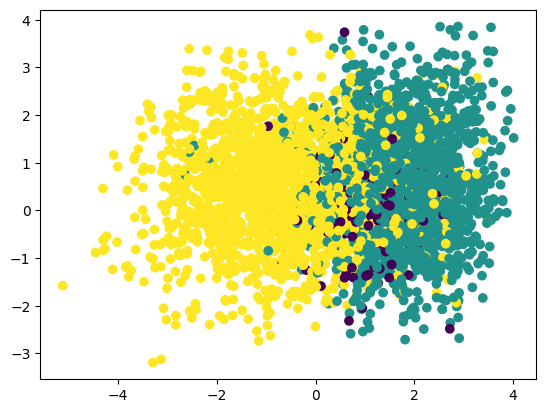

In [33]:
plt.scatter(X[:,2], X[:,3], c=list(y))

# Improve ML Model via data-centric techniques

We train a simple neural network model (Multi-Layer Perceptron classifier) and evaluate it on the given test set. 
Note that the evaluation metric used is `balanced_accuracy`. This is the accuracy amongst all examples in a given class, averaged over all classes, which better represents performance on minority classes.

You should never change the test data labels `y_test` in this lab, nor the neural network model. You may change the training data `X`, `y` as you see fit, and update `X_test` accordingly so your model is able to make predictions on it.

In [34]:
def train_evaluate_model(X, y, X_test, y_test):
    model = MLPClassifier(early_stopping=True, random_state=SEED)
    model.fit(X, y)
    predictions = model.predict(X_test)
    acc = balanced_accuracy_score(y_true=y_test, y_pred=predictions)
    print(f"Balanced accuracy = {acc}")
    return predictions

A baseline version of the model is trained on the original given data:

In [35]:
predictions = train_evaluate_model(X, y, X_test, y_test)

Balanced accuracy = 0.5759397707696671


# Exercise

Your goal is to produce a version of this same model that has much better test accuracy! 
You should accomplish this by changing `X` and `y` as you see fit. Consider various ideas presented in the lecture and look through the data yourself to see if other ideas come to mind! Greater than 80% test accuracy is achievable without modifying the model at all. If you choose to drop/add features to `X` or renormalize some values, then you'll want to apply these operations to `X_test` as well.

In [64]:
# Compute label issues

import cleanlab
from sklearn.model_selection import cross_val_predict

model = MLPClassifier(early_stopping=True, random_state=SEED)
pred_probs = cross_val_predict(model, X, y, cv=5, method="predict_proba")

cl_issue_idx = cleanlab.filter.find_label_issues(y, pred_probs, return_indices_ranked_by='self_confidence')

df_clean = df.drop(cl_issue_idx, inplace=False)
y_clean = df_clean["y"].values
X_clean = df_clean.drop(columns=["y"], inplace=False).values

predictions = train_evaluate_model(X_clean, y_clean, X_test, y_test)
print("number of issues in training set: ", len(cl_issue_idx))

Balanced accuracy = 0.5715291371313923
number of issues in training set:  289


In [68]:
counts_per_label = np.unique(df['y'], return_counts=True)[1]
issues_per_label = np.unique(df.loc[cl_issue_idx, 'y'], return_counts=True)[1]
print("issue with respective to labels", [str((i/j)*100) + '%' for i,j in zip(issues_per_label, counts_per_label)] )


issue with respective to labels ['30.337078651685395%', '4.418103448275862%', '8.333333333333332%']


Seems a class less in number is giving more problems
1. Check the number of labels for all datapoints
2. CHeck the order

In [69]:
print("unique with counts", np.unique(y, return_counts=True))
print("indices of label 1", np.argwhere(y == 1))
print("indices of label 2", np.argwhere(y == 2))


unique with counts (array([0, 1, 2]), array([ 178, 1856, 1836]))
indices of label 1 [[   1]
 [   2]
 [   3]
 ...
 [3866]
 [3868]
 [3869]]
indices of label 2 [[   0]
 [   4]
 [   6]
 ...
 [3863]
 [3864]
 [3867]]


In [84]:
# Use clean dataset and oversample label '0' to a 1700
print("number of labels in cleaned dataset", np.unique(y_clean, return_counts=True)[1])

df_label_0_oversampled = pd.concat([df_clean[df_clean['y'] == 0]]*12, ignore_index=True)
df_class_balanced = pd.concat([df_clean, df_label_0_oversampled], ignore_index=True)

print("number of labels in balanced dataset", np.unique(df_class_balanced['y'].values, return_counts=True)[1])

y_balanced = df_class_balanced["y"].values
X_balanced = df_class_balanced.drop(columns=["y"], inplace=False).values

predictions = train_evaluate_model(X_balanced, y_balanced, X_test, y_test)



number of labels in cleaned dataset [ 124 1774 1683]
number of labels in balanced dataset [1612 1774 1683]
Balanced accuracy = 0.7890203028217698


In [91]:
# Try using smote
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.5 MB/s eta 0:00:00


In [93]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

predictions = train_evaluate_model(X_smote, y_smote, X_test, y_test)


Balanced accuracy = 0.799441790755699


In [94]:
oversample = SMOTE()
X_smote_clean, y_smote_clean = oversample.fit_resample(X_clean, y_clean)

predictions = train_evaluate_model(X_smote_clean, y_smote_clean, X_test, y_test)

Balanced accuracy = 0.8087364034861094


In [95]:
# remove outliers for simple oversampling with cleaned data

from cleanlab.outlier import OutOfDistribution

n_outlier = 100  # try different values to determine good one

knn = sklearn.neighbors.NearestNeighbors(n_neighbors=10).fit(X_balanced)
ood = OutOfDistribution({"knn": knn})  # find outliers based on Euclidean nearest neighbors rather than cleanlab's cosine distance default
ood_scores = ood.score(features=X_balanced)
outlier_examples = np.argsort(ood_scores)[:n_outlier]
outlier_examples = [out for out in outlier_examples]

X_outliers_removed = np.delete(X_balanced, outlier_examples, axis=0)
y_outliers_removed =  np.delete(y_balanced, outlier_examples)

predictions = train_evaluate_model(X_outliers_removed, y_outliers_removed, X_test, y_test)



Balanced accuracy = 0.8062561617793954


In [101]:
# remove outliers for SMOTE oversampling with raw data

from cleanlab.outlier import OutOfDistribution

n_outlier = 100  # try different values to determine good one

knn = sklearn.neighbors.NearestNeighbors(n_neighbors=10).fit(X_smote)
ood = OutOfDistribution({"knn": knn})  # find outliers based on Euclidean nearest neighbors rather than cleanlab's cosine distance default
ood_scores = ood.score(features=X_smote)
outlier_examples = np.argsort(ood_scores)[:n_outlier]
outlier_examples = [out for out in outlier_examples]

X_outliers_removed = np.delete(X_smote, outlier_examples, axis=0)
y_outliers_removed =  np.delete(y_smote, outlier_examples)

predictions = train_evaluate_model(X_outliers_removed, y_outliers_removed, X_test, y_test)

Balanced accuracy = 0.808359088980049


In [100]:
# remove outliers for SMOTE oversampling with cleaned data

from cleanlab.outlier import OutOfDistribution

n_outlier = 100  # try different values to determine good one

knn = sklearn.neighbors.NearestNeighbors(n_neighbors=10).fit(X_smote_clean)
ood = OutOfDistribution({"knn": knn})  # find outliers based on Euclidean nearest neighbors rather than cleanlab's cosine distance default
ood_scores = ood.score(features=X_smote_clean)
outlier_examples = np.argsort(ood_scores)[:n_outlier]
outlier_examples = [out for out in outlier_examples]

X_outliers_removed = np.delete(X_smote_clean, outlier_examples, axis=0)
y_outliers_removed =  np.delete(y_smote_clean, outlier_examples)

predictions = train_evaluate_model(X_outliers_removed, y_outliers_removed, X_test, y_test)

Balanced accuracy = 0.8106828365896579
